# Project-BipedalWalker-Hardcore

## Bipedal Walker Hardcore Problem

"BipedalWalkerHardcore-v3" task is an advanced version of "BipedalWalker-v3" with ladders, stumps, and pitfalls. 

The state and action space are exactly the same as "BipedalWalker-v3".

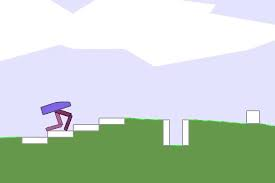


### Formulation

- *State* $s$: 
The state consists of 24 observations as follows:

Num   | Observation                |  Min   |   Max  | Mean
------|----------------------------|--------|--------|------   
0     | hull_angle                 |  0     | 2$\pi$ |  0.5
1     | hull_angularVelocity       |  -inf  |  +inf  |  -
2     | vel_x                      |  -1    |  +1    |  -
3     |  vel_y                     |  -1    |  +1    |  -
4     | hip_joint_1_angle          |  -inf  |  +inf  |  -
5     | hip_joint_1_speed          |  -inf  |  +inf  |  -
6     | knee_joint_1_angle         |  -inf  |  +inf  |  -
7     | knee_joint_1_speed         |  -inf  |  +inf  |  -
8     | leg_1_ground_contact_flag  |  0     |  1     |  -
9     | hip_joint_2_angle          |  -inf  |  +inf  |  -
10    | hip_joint_2_speed          |  -inf  |  +inf  |  -
11    | knee_joint_2_angle         |  -inf  |  +inf  |  -
12    | knee_joint_2_speed         |  -inf  |  +inf  |  -
13    | leg_2_ground_contact_flag  |  0     |  1     |  -
14-23 | 10 lidar readings          |  -inf  |  +inf  |  -


- *Action $a$*:
The continuous action has four dimensions:

Num | Name                        | Min  | Max  
----|-----------------------------|------|------
0   | Hip_1 (Torque / Velocity)   |  -1  | +1
1   | Knee_1 (Torque / Velocity)  |  -1  | +1
2   | Hip_2 (Torque / Velocity)   |  -1  | +1
3   | Knee_2 (Torque / Velocity)  |  -1  | +1


- *Reward $r(s,a)$*:
    
    Reward is given for moving forward, the walker can get 300+ points when reaching the far end. If the walker falls, it gets -100.
    

- Episode Termination

    An episode terminates when one of the following occurs:
  - The walker reaches the far right side of the environment.
  - The walker touches the ground.
  - Episode length is greater than 1600.



- *Objective*:
    To get an average reward as more as possible over 30 consecutive trials (episodes).


In [ ]:
# Import packages. Run this cell.
!pip install Box2D
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random
import torch.optim as optim

     |████████████████████████████████| 1.3 MB 8.1 MB/s 


### Task
(100 points)

You are allowed to solve the "BipedalWalkerHardcore-v3" using any algorithms as long as you could get a satisfied reward.

You can also complete the function ``learn_and_update_weights_by_replay(self,training_iterations, weight, totrain):`` to implement the algorithm TD3-FORK which can solve the task successfully. In particular, you need to complement 
- Training system netwrok. (mapping from [s,a] to [s'])
- Training Actor. (mapping form [s] to [a])

The details can be found in this paper [Paper](https://arxiv.org/pdf/2010.01652.pdf).

### Requirement

- After training your algorithm, please save your well trained agent as ``agent.py``, upload ``agent.py`` and related files to Gradescope. We will test your policy (actor) for 30 episodes on Gradescope. 

- Do not modify the function ``select_action(self, state)`` in the class ``Agent`` which is used for testing your policy.

(We will provide a sample agent in the following section.)


**Note**: 
- Do not try to use a large ``Actor`` network, 2048 * 2048 is large enough and 256 * 256 is sufficient. Large network will eat a lot of running time and remind that the running time limit is $30$ minutes.

- You can use GPU to accelerate the training, but make sure that the actor network you saved is on CPU.

- We also provide some training tricks in the following section.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Actor Neural Network
class Actor(nn.Module):
    def __init__(self, state_size, action_size, seed, fc_units=512, fc1_units=512):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.fc2 = nn.Linear(fc_units, fc1_units)
        self.fc3 = nn.Linear(fc1_units, action_size)

    def forward(self, state):
        """
        Build an actor (policy) network that maps states -> actions.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
        Returns:
            action: torch.Tensor with shape (batch_size, action_size)
        """
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.torch.tanh(self.fc3(x))

# Q1-Q2-Critic Neural Network  
  
class Critic(nn.Module):
    """
    Args:
        state_size: state dimension
        action_size: action dimension
        fc_units: number of neurons in one fully connected hidden layer
    """
    def __init__(self, state_size, action_size, seed, fc1_units=512, fc2_units=512):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)

        # Q1 architecture
        self.l1 = nn.Linear(state_size + action_size, fc1_units)
        self.l2 = nn.Linear(fc1_units, fc2_units)
        self.l3 = nn.Linear(fc2_units, 1)

        # Q2 architecture
        self.l4 = nn.Linear(state_size + action_size, fc1_units)
        self.l5 = nn.Linear(fc1_units, fc2_units)
        self.l6 = nn.Linear(fc2_units, 1)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps state-action pairs -> Q-values.
        Args:
            state: torch.Tensor with shape (batch_size, state_size)
            action: torch.Tensor with shape (batch_size, action_size)
        Returns:
            x_1: torch.Tensor with shape (batch_size, 1)
            x_2: torch.Tensor with shape (batch_size, 1)
        """
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        x2 = F.relu(self.l4(xa))
        x2 = F.relu(self.l5(x2))
        x2 = self.l6(x2)

        return x1, x2


class SysModel(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        super(SysModel, self).__init__()
        self.l1 = nn.Linear(state_size + action_size, fc1_units)
        self.l2 = nn.Linear(fc1_units, fc2_units)
        self.l3 = nn.Linear(fc2_units, state_size)


    def forward(self, state, action):
        """Build a system model to predict the next state at given state and action.
        Returns:
            state: torch.Tensor with shape (batch_size, state_size)
        """
        xa = torch.cat([state, action], 1)

        x1 = F.relu(self.l1(xa))
        x1 = F.relu(self.l2(x1))
        x1 = self.l3(x1)

        return x1


class RModel(nn.Module):
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=256):
        super(RModel, self).__init__()
        # input s_t, a_t, s_{t+1}
        self.l1 = nn.Linear(2 * state_size + action_size, fc1_units)
        self.l2 = nn.Linear(fc1_units,fc2_units)
        self.l3 = nn.Linear(fc2_units, 1)


    def forward(self, state, next_state, action):
      ssa = torch.cat([state, next_state, action], 1)

      r1 = F.relu(self.l1(ssa))
      r1 = F.relu(self.l2(r1))
      r1 = self.l3(r1)
      return r1

"""
TD3_FORK AGENT
"""

class Agent:
    def __init__(
        self,
        load = False,
        gamma = 0.99, #discount factor
        lr_actor = 3e-4,  # learning rate for actor network
        lr_critic = 3e-4, # learning rate for critic network
        lr_sysmodel = 3e-4, # learning rate for system network

        lr_rmodel = 3e-4,

        batch_size = 100,  # mini-batch size
        buffer_capacity = 1000000, # reply buffer capacitty
        tau = 0.005,  #target network update factor
        random_seed = np.random.randint(1,10000),  #random seed
        policy_noise=0.2,   # noise added to actor
        std_noise = 0.1,    # standard deviation for smoothing noise added to target policy
        noise_clip=0.5,   #noise bound
        policy_freq=2, #target network update period
        threshold = 0.01 #threshold of monitoring weights
    ):
        self.device = torch.device("cuda")
        self.env = gym.make('BipedalWalkerHardcore-v3')
        self.create_actor()
        self.create_critic()
        self.create_sysmodel()

        self.create_rmodel()

        self.act_opt = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.crt_opt = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.sys_opt = optim.Adam(self.sysmodel.parameters(), lr=lr_sysmodel) #define system model

        self.r_opt = optim.Adam(self.rmodel.parameters(), lr=lr_rmodel) #define system reward model

        self.set_weights()
        self.replay_memory_buffer = deque(maxlen = buffer_capacity)
        self.replay_memory_bufferd_dis = deque(maxlen = buffer_capacity)
        self.batch_size = batch_size
        self.tau = tau
        self.policy_freq = policy_freq
        self.gamma = gamma
        self.upper_bound = self.env.action_space.high[0] #action space upper bound
        self.lower_bound = self.env.action_space.low[0]  #action space lower bound
        self.obs_upper_bound = self.env.observation_space.high[0] #state space upper bound
        self.obs_lower_bound = self.env.observation_space.low[0]  #state space lower bound
        self.policy_noise = policy_noise
        self.noise_clip = noise_clip
        self.std_noise = std_noise   

        self.threshold = threshold
 

    def create_actor(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0],
            'seed':            88
        }
        self.actor = Actor(**params).to(self.device)
        self.actor_target = Actor(**params).to(self.device)
        #self.actor.load_state_dict(torch.load('drive/My Drive/rl_coding_proj/actor.pth', map_location=torch.device('cpu'))) #a pre saved model
        #self.actor_target.load_state_dict(torch.load('drive/My Drive/rl_coding_proj/actor.pth', map_location=torch.device('cpu'))) #a pre saved model


    def create_critic(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0],
            'seed':            88
        }
        self.critic = Critic(**params).to(self.device)
        self.critic_target = Critic(**params).to(self.device)

    def create_sysmodel(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0]
        }
        self.sysmodel = SysModel(**params).to(self.device)
        #self.sysmodel.apply(self.init_weights)

    def create_rmodel(self):
        params = {
            'state_size':      self.env.observation_space.shape[0],
            'action_size':     self.env.action_space.shape[0]
        }
        self.rmodel = RModel(**params).to(self.device)

    def set_weights(self):
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target.load_state_dict(self.critic.state_dict())


    def add_to_replay_memory(self, transition, buffername):
        #add samples to replay memory
        buffername.append(transition)

    def get_random_sample_from_replay_mem(self, buffername):
        #random samples from replay memory
        random_sample = random.sample(buffername, self.batch_size)
        return random_sample

    def init_weights(self,model):
        if type(model) == nn.Linear:
          torch.nn.init.xavier_uniform_(model.weight)
          model.bias.data.fill_(0.001)


    def learn_and_update_weights_by_replay(self,training_iterations, weight, totrain):
        """Update policy and value parameters using given batch of experience tuples.
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        weight is used for training  actor
        To train indicates whether we will train actor or not. We may not need to train Actor when the performance is good enough.
        This is a placeholder, you can define your criteria.
        """
        if len(self.replay_memory_buffer) < 1e4:
            return 1
        for it in range(training_iterations):
            mini_batch = self.get_random_sample_from_replay_mem(self.replay_memory_buffer)
            state_batch = torch.from_numpy(np.vstack([i[0] for i in mini_batch])).float().to(self.device)
            action_batch = torch.from_numpy(np.vstack([i[1] for i in mini_batch])).float().to(self.device)
            reward_batch = torch.from_numpy(np.vstack([i[2] for i in mini_batch])).float().to(self.device)
            next_state_batch = torch.from_numpy(np.vstack([i[3] for i in mini_batch])).float().to(self.device)
            done_list = torch.from_numpy(np.vstack([i[4] for i in mini_batch]).astype(np.uint8)).float().to(self.device)

            # Training and updating Actor & Critic networks.
            
            #Train Critic
            with torch.no_grad():
              target_actions = self.actor_target(next_state_batch)
              offset_noises = torch.FloatTensor(action_batch.shape).data.normal_(0, self.policy_noise).to(self.device)

              #clip noise
              offset_noises = offset_noises.clamp(-self.noise_clip, self.noise_clip)
              target_actions = (target_actions + offset_noises).clamp(self.lower_bound, self.upper_bound)

              #Compute the target Q value
              Q_targets1, Q_targets2 = self.critic_target(next_state_batch, target_actions)
              Q_targets = torch.min(Q_targets1, Q_targets2)
              Q_targets = reward_batch + self.gamma * Q_targets * (1 - done_list)

            #Compute current Q estimates
            current_Q1, current_Q2 = self.critic(state_batch, action_batch)
            # Compute critic loss
            critic_loss = F.mse_loss(current_Q1, Q_targets.detach()) + F.mse_loss(current_Q2, Q_targets.detach())
            # Optimize the critic
            self.crt_opt.zero_grad()
            critic_loss.backward()
            self.crt_opt.step()

            


            """Train Sysmodel"""       
 

            # YOUR CODE HERE


            loss_fn = torch.nn.SmoothL1Loss()
            next_state_pred = self.sysmodel(state_batch, action_batch).clamp(self.obs_lower_bound, self.obs_upper_bound)
            sys_loss = loss_fn(next_state_pred, next_state_batch.detach())

            self.sys_opt.zero_grad()
            sys_loss.backward()
            self.sys_opt.step()
            sys_loss_num = sys_loss.item()


            """Train Reward model"""


            loss_fn_1 = torch.nn.MSELoss()
            pred_r = self.rmodel(state_batch, next_state_batch, action_batch)
            r_loss = loss_fn_1(pred_r, reward_batch.detach())

            self.r_opt.zero_grad()
            r_loss.backward()
            self.r_opt.step()
            r_loss_num = r_loss.item()
            #print("reward model loss: ", r_loss.item())


            #print("sys loss term: ", sys_loss_num)
            usesys = 1 if sys_loss_num < self.threshold  else 0

            
            
            """Train Actor"""
            #Train Actor
            # Delayed policy updates
            # Update self.actor once every policy_delay times for each update of self.critic

            if it % self.policy_freq == 0:
            
              first_loss = torch.mean(self.critic(state_batch, self.actor(state_batch))[0])

              if usesys == 1:
                # telta s_{t+1}
                pred_next_state = self.sysmodel(state_batch, self.actor(state_batch)).clamp(self.obs_lower_bound,self.obs_upper_bound)
                # second term 
                # r ( s_{t}, s_{t+1}, actor(s_{t}))
                pred_next_r = self.rmodel(state_batch.detach() ,pred_next_state.detach(), self.actor(state_batch.detach()))

                # telta s_{t+2}
                pred_next_next_state = self.sysmodel(pred_next_state, self.actor(pred_next_state.detach())).clamp(self.obs_lower_bound,self.obs_upper_bound)
                # third term
                # r ( s_{t+1}, s_{t+2}, actor(s_{t+1}))
                pred_next_next_r = self.rmodel(pred_next_state.detach() ,pred_next_next_state.detach(), self.actor(pred_next_state.detach()))

              
                # compute last term
                action_next_next = self.actor(pred_next_next_state.detach())
                last_loss = self.critic(pred_next_next_state.detach(), action_next_next)[0]
                

                final_loss = -first_loss - weight * torch.mean( pred_next_r + self.gamma * pred_next_next_r + self.gamma * self.gamma * last_loss )

              else:
                final_loss = -first_loss


              # Optimize the actor
              if totrain == 1:
                self.crt_opt.zero_grad()
                self.sys_opt.zero_grad()
                self.r_opt.zero_grad()

                self.act_opt.zero_grad()
                final_loss.backward()
                self.act_opt.step()

              self.soft_update_target(self.actor, self.actor_target)
              self.soft_update_target(self.critic, self.critic_target)

              

            ### END SOLUTION
            
                

    def soft_update_target(self,local_model,target_model):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data)

    def policy(self,state):
        """select action based on ACTOR but with noise added"""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.actor.eval()
        with torch.no_grad():
            actions = self.actor(state).cpu().data.numpy()
        self.actor.train()
        # Adding noise to action
        shift_action = np.random.normal(0, self.std_noise, size=self.env.action_space.shape[0])
        sampled_actions = (actions + shift_action)
        # We make sure action is within bounds
        legal_action = np.clip(sampled_actions,self.lower_bound,self.upper_bound)
        return np.squeeze(legal_action)


    def select_action(self,state):
        """select action based on ACTOR"""
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        with torch.no_grad():
            actions = self.actor_target(state).cpu().data.numpy()
        return np.squeeze(actions)





In [ ]:
import time
import os
"""
Training Agent and some Training Tricks
"""
gym.logger.set_level(40)
max_steps = 3000
falling_down = 0


if __name__ == '__main__':
    env = gym.make('BipedalWalkerHardcore-v3')
    agent = Agent(batch_size = 100) #Use TD3 for example
    total_episodes = 10000
    start_timestep=0            #time_step to select action based on Actor
    time_start = time.time()        # Init start time
    ep_reward_list = []
    avg_reward_list = []
    total_timesteps = 0
    save_time = 0
    expcount = 0
    totrain = 0

    best_reward = -9999
    
    GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "rl_coding_proj"
    GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
    actor_path = "actor_512.pth"
    path = os.path.join(GOOGLE_DRIVE_PATH, actor_path)

    for ep in range(total_episodes):
        state = env.reset()
        episodic_reward = 0
        timestep = 0
        temp_replay_buffer = []
        for st in range(max_steps):
            # Select action randomly or according to policy
            if total_timesteps < start_timestep:
                action = env.action_space.sample()
            else:
                action = agent.policy(state)
            # Recieve state and reward from environment.
            next_state, reward, done, info = env.step(action)
            #change original reward from -100 to -5 and 5*reward for other values
            episodic_reward += reward
            if reward == -100:
                add_reward = -1
                reward = -5
                falling_down += 1 #check whether the bipedal falls down or not
                expcount += 1
            else:
                add_reward = 0
                reward = 5 * reward

            temp_replay_buffer.append((state, action, reward, next_state, done))
            
            # End this episode when `done` is True
            # We add few samples to replay buffer when episodic reward is higher.
            if done:
                if add_reward == -1 or episodic_reward < 250:            
                    totrain = 1
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                elif expcount > 0 and np.random.rand() > 0.5:  
                    totrain = 1
                    expcount -= 10
                    for temp in temp_replay_buffer: 
                        agent.add_to_replay_memory(temp, agent.replay_memory_buffer)
                break
            state = next_state
            timestep += 1     
            total_timesteps += 1
        
        ep_reward_list.append(episodic_reward)
        # Mean of last 100 episodes
        avg_reward = np.mean(ep_reward_list[-100:])
        avg_reward_list.append(avg_reward)
        s = (int)(time.time() - time_start)

        #Training agent only when new experiences are added to the replay buffer
        #If totrain == 1 we update actor network else we only update critic network

        #weight for FORK actor
        weight =  (1 - np.clip(np.mean(ep_reward_list[-100:])/320, 0, 1)) * 1.5
        #print("weight: ", weight)
        
        if totrain == 1:
            agent.learn_and_update_weights_by_replay(timestep, weight, totrain)
        else: 
            #print("totrain = 0!")
            agent.learn_and_update_weights_by_replay(100, weight, totrain)
        totrain = 0

        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Episode Reward: {:.2f}, Moving Avg.Reward: {:.2f}, Time: {:02}:{:02}:{:02}'.format(ep, total_timesteps, timestep,
                      episodic_reward, avg_reward, s//3600, s%3600//60, s%60)) 
        if avg_reward > 300:

          if avg_reward > best_reward:
            best_reward = avg_reward
            ######
            torch.save(agent.actor.to("cpu").state_dict(), path)
            ######
            agent.actor.to("cuda")
            print(os.listdir(GOOGLE_DRIVE_PATH))
          
            if avg_reward > 310:
              break
        

        

串流輸出內容已截斷至最後 5000 行。
Ep. 994, Timestep 245894,  Ep.Timesteps 999, Episode Reward: 167.36, Moving Avg.Reward: 30.72, Time: 00:40:00
Ep. 995, Timestep 246081,  Ep.Timesteps 187, Episode Reward: -49.06, Moving Avg.Reward: 30.58, Time: 00:40:10
Ep. 996, Timestep 246386,  Ep.Timesteps 305, Episode Reward: -6.92, Moving Avg.Reward: 30.75, Time: 00:40:12
Ep. 997, Timestep 246787,  Ep.Timesteps 401, Episode Reward: 25.02, Moving Avg.Reward: 31.72, Time: 00:40:16
Ep. 998, Timestep 246961,  Ep.Timesteps 174, Episode Reward: -66.55, Moving Avg.Reward: 30.15, Time: 00:40:20
Ep. 999, Timestep 247806,  Ep.Timesteps 845, Episode Reward: 165.54, Moving Avg.Reward: 31.54, Time: 00:40:22
Ep. 1000, Timestep 248058,  Ep.Timesteps 252, Episode Reward: -23.71, Moving Avg.Reward: 30.77, Time: 00:40:30
Ep. 1001, Timestep 248316,  Ep.Timesteps 258, Episode Reward: -41.71, Moving Avg.Reward: 30.89, Time: 00:40:33
Ep. 1002, Timestep 248767,  Ep.Timesteps 451, Episode Reward: 32.16, Moving Avg.Reward: 31.52, Time

In [ ]:
import time
"""
Training Agent and some Training Tricks
"""
gym.logger.set_level(40)
max_steps = 3000
falling_down = 0


if __name__ == '__main__':
    env = gym.make('BipedalWalkerHardcore-v3')
    agent = Agent() #Use TD3 for example
    total_episodes = 1000
    start_timestep=0            #time_step to select action based on Actor
    time_start = time.time()        # Init start time
    ep_reward_list = []
    avg_reward_list = []
    total_timesteps = 0
    save_time = 0
    expcount = 0
    totrain = 0

    for ep in range(total_episodes):
        state = env.reset()
        episodic_reward = 0
        timestep = 0
        temp_replay_buffer = []
        for st in range(max_steps):
            
            action = agent.select_action(state)
            # Recieve state and reward from environment.
            next_state, reward, done, info = env.step(action)
            #change original reward from -100 to -5 and 5*reward for other values
            episodic_reward += reward
            

            #temp_replay_buffer.append((state, action, reward, next_state, done))
            
            # End this episode when `done` is True
            # We add few samples to replay buffer when episodic reward is higher.
            if done:
              break

            state = next_state
            timestep += 1     
            total_timesteps += 1
        
        ep_reward_list.append(episodic_reward)
        # Mean of last 100 episodes
        avg_reward = np.mean(ep_reward_list[-100:])
        avg_reward_list.append(avg_reward)
        s = (int)(time.time() - time_start)

        #Training agent only when new experiences are added to the replay buffer
        #If totrain == 1 we update actor network else we only update critic network

        #weight for FORK actor
        #weight =  (1 - np.clip(np.mean(ep_reward_list[-100:])/300, 0, 1)) 
        #print("weight: ", weight)
        #totrain = 0
        #if totrain == 1:
        #    agent.learn_and_update_weights_by_replay(timestep, weight, totrain)
        #else: 
            #print("totrain = 0!")
        #    agent.learn_and_update_weights_by_replay(100, weight, totrain)
        

        print('Ep. {}, Timestep {},  Ep.Timesteps {}, Episode Reward: {:.2f}, Moving Avg.Reward: {:.2f}, Time: {:02}:{:02}:{:02}'.format(ep, total_timesteps, timestep,
                      episodic_reward, avg_reward, s//3600, s%3600//60, s%60)) 
        
        

        

Ep. 0, Timestep 59,  Ep.Timesteps 59, Episode Reward: -110.29, Moving Avg.Reward: -110.29, Time: 00:00:00
Ep. 1, Timestep 118,  Ep.Timesteps 59, Episode Reward: -110.55, Moving Avg.Reward: -110.42, Time: 00:00:00
Ep. 2, Timestep 177,  Ep.Timesteps 59, Episode Reward: -110.58, Moving Avg.Reward: -110.48, Time: 00:00:00
Ep. 3, Timestep 236,  Ep.Timesteps 59, Episode Reward: -110.57, Moving Avg.Reward: -110.50, Time: 00:00:00
Ep. 4, Timestep 295,  Ep.Timesteps 59, Episode Reward: -110.59, Moving Avg.Reward: -110.52, Time: 00:00:00
Ep. 5, Timestep 354,  Ep.Timesteps 59, Episode Reward: -110.46, Moving Avg.Reward: -110.51, Time: 00:00:00
Ep. 6, Timestep 413,  Ep.Timesteps 59, Episode Reward: -110.41, Moving Avg.Reward: -110.49, Time: 00:00:00
Ep. 7, Timestep 472,  Ep.Timesteps 59, Episode Reward: -110.39, Moving Avg.Reward: -110.48, Time: 00:00:00
Ep. 8, Timestep 531,  Ep.Timesteps 59, Episode Reward: -110.35, Moving Avg.Reward: -110.47, Time: 00:00:00
Ep. 9, Timestep 589,  Ep.Timesteps 58,

KeyboardInterrupt: ignored

In [ ]:
# Save the 
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "rl_coding_proj"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
actor_path = "actor_512.pth"
path = os.path.join(GOOGLE_DRIVE_PATH, actor_path)
torch.save(agent.actor.to("cpu").state_dict(), path)
print(os.listdir(GOOGLE_DRIVE_PATH))